In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('/content/weather_data.csv')
data['date'] = pd.to_datetime(data['date'])
temperature = data['temperature']

In [ ]:
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    2557 non-null   datetime64[ns]
 1   temperature             2557 non-null   float64       
 2   temperature_normalized  2557 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 60.1 KB
None
                      date  temperature  temperature_normalized
count                 2557  2557.000000             2557.000000
mean   2017-07-02 00:00:00    10.017472                0.545292
min    2014-01-01 00:00:00     3.337291                0.000000
25%    2015-10-02 00:00:00     9.335195                0.489599
50%    2017-07-02 00:00:00    10.031778                0.546460
75%    2019-04-02 00:00:00    10.681384                0.599486
max    2020-12-31 00:00:00    15.587945                1.000000
std              

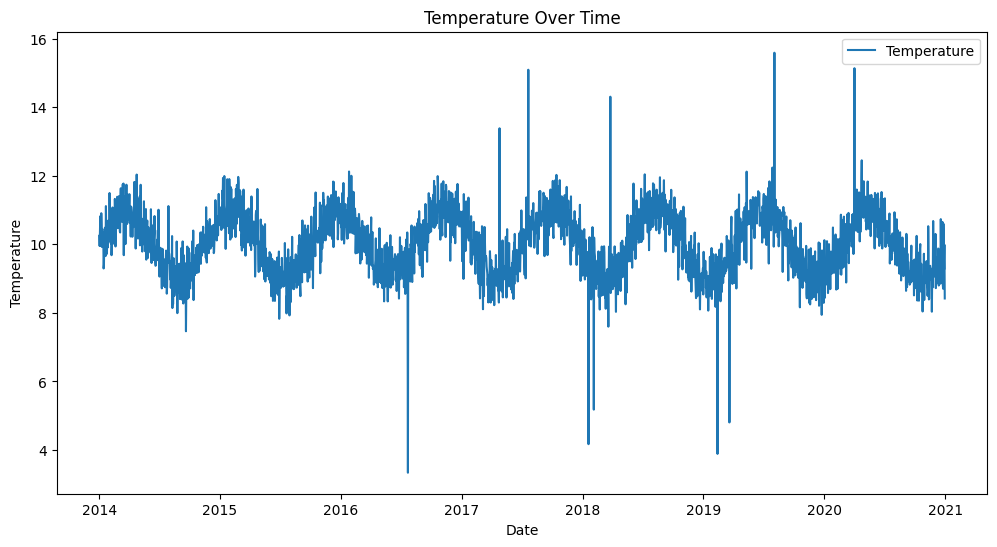

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['temperature'], label='Temperature')
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [ ]:
scaler = MinMaxScaler()
data['temperature_normalized'] = scaler.fit_transform(data[['temperature']])

In [ ]:
train_data, test_data = train_test_split(data['temperature_normalized'], test_size=0.2, shuffle=False)
train_data = np.array(train_data).reshape(-1, 1, 1)
test_data = np.array(test_data).reshape(-1, 1, 1)

In [ ]:
model = Sequential([
    LSTM(64, activation='relu', input_shape=(1, 1), return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    Dense(16, activation='relu'),
    RepeatVector(1),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(1))
])
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = model.fit(train_data, train_data, epochs=50, batch_size=32, validation_split=0.2, shuffle=False)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.2839 - val_loss: 0.1744
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1008 - val_loss: 0.0070
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - val_loss: 0.0042
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0031 - val_loss: 0.0039
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027 - val_loss: 0.0033
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 10/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 11/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 12/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0014 - va

In [ ]:
reconstructed_data = model.predict(test_data)
reconstruction_error = np.mean(np.square(reconstructed_data - test_data), axis=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
threshold = np.percentile(reconstruction_error, 95)

In [ ]:
anomalies = reconstruction_error.flatten() > threshold

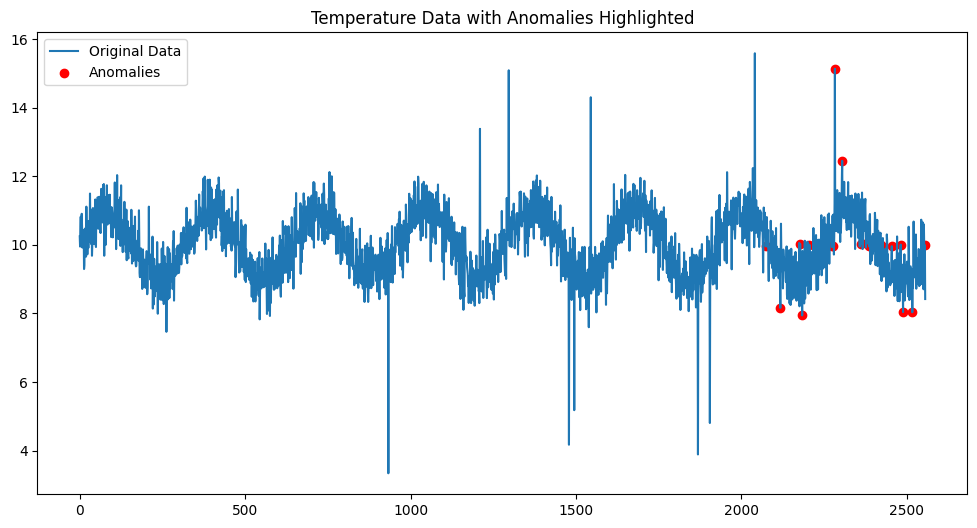

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data['temperature'], label="Original Data")
plt.scatter(
    data.index[-len(test_data):][anomalies],
    data['temperature'].iloc[-len(test_data):].iloc[anomalies],
    color='red', label="Anomalies"
)
plt.title("Temperature Data with Anomalies Highlighted")
plt.legend()
plt.show()

**Insights**

The line plot of the temperature data shows the daily variations over the dataset's timeline

Most data points have low reconstruction errors, indicating that they fit well with the model's understanding of normal temperature behavior.

High reconstruction errors correspond to unusual temperature values or unexpected deviations.

The anomalies are highlighted in the plot and correspond to days where the temperature significantly deviated from the norm.

The 95th percentile threshold effectively separates typical temperatures from outliers.